# Imports

In [1]:
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model

## Checking GPU

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Creating the Datasets

Define paramters for the data loaders

In [3]:
batch_size = 16
img_height = 48
img_width = 48
color_mode = 'rgb' # One of "grayscale", "rgb", "rgba".
validation_split = 0.2

dataset = "CK+"
model_name = "VGG16"

train_data = "data/"+ dataset + "/train/"
test_data = "data/"+ dataset + "/test/"

print(train_data)
print(test_data)

data/CK+/train/
data/CK+/test/


Load the data into the datasets

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data,
    color_mode = color_mode,
    validation_split=validation_split,
    subset="training",
    seed=123,
    label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_data,
    color_mode = color_mode,
    validation_split=validation_split,
    label_mode="categorical",
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data,
    seed=123,
    label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 720 files belonging to 7 classes.
Using 576 files for training.
Found 720 files belonging to 7 classes.
Using 144 files for validation.
Found 182 files belonging to 7 classes.


View the classes in the dataset

In [5]:
class_names = train_ds.class_names
print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


## Configuring the Datset
Enable buffered prefetching so you can yield data from disk without having I/O become blocking

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Creating the Model

In [7]:
from tensorflow.keras.layers import Input, Conv2D , MaxPool2D, Flatten, Dense 
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

num_classes = len(class_names)

# input
input = Input(shape=(img_height, img_width, 3) , name="img")

# Rescaling if the data is RGB
x = layers.experimental.preprocessing.Rescaling(1./255)(input)

# 1st Conv Block
x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu', name="Conv1.1")(x)
x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu', name="Conv1.2")(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same', name="MaxPool2D_1")(x)

# 2nd Conv Block
x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu', name="Conv2.1")(x)
x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu', name="Conv2.2")(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same', name="MaxPool2D_2")(x)

# 3rd Conv block
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu', name="Conv3.1")(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu', name="Conv3.2")(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu', name="Conv3.3")(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same', name="MaxPool2D_3" )(x)

# 4th Conv block
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu', name="Conv4.1")(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu', name="Conv4.2")(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu', name="Conv4.3")(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same', name="MaxPool2D_4")(x)

# 5th Conv block
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu', name="Conv5.1")(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu', name="Conv5.2")(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu', name="Conv5.3")(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same', name="MaxPool2D_5")(x)

# Fully connected layers
x = Flatten()(x)
x = Dense(units = 4096, activation ='relu', name="Dense1")(x)
x = Dense(units = 4096, activation ='relu', name="Dense2")(x)

output = Dense(units = num_classes, activation ='softmax', name="DenseFinal")(x)

model = Model (inputs=input, outputs =output , name="VGG16")

## Compile the model

In [8]:
model.compile(optimizer = Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

## View Model Summary

In [9]:
model.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 48, 48, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 48, 48, 3)         0         
                                                                 
 Conv1.1 (Conv2D)            (None, 48, 48, 64)        1792      
                                                                 
 Conv1.2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 MaxPool2D_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 Conv2.1 (Conv2D)            (None, 24, 24, 128)       73856     
                                                                 
 Conv2.2 (Conv2D)            (None, 24, 24, 128)       147584

Plot the the CNN Model

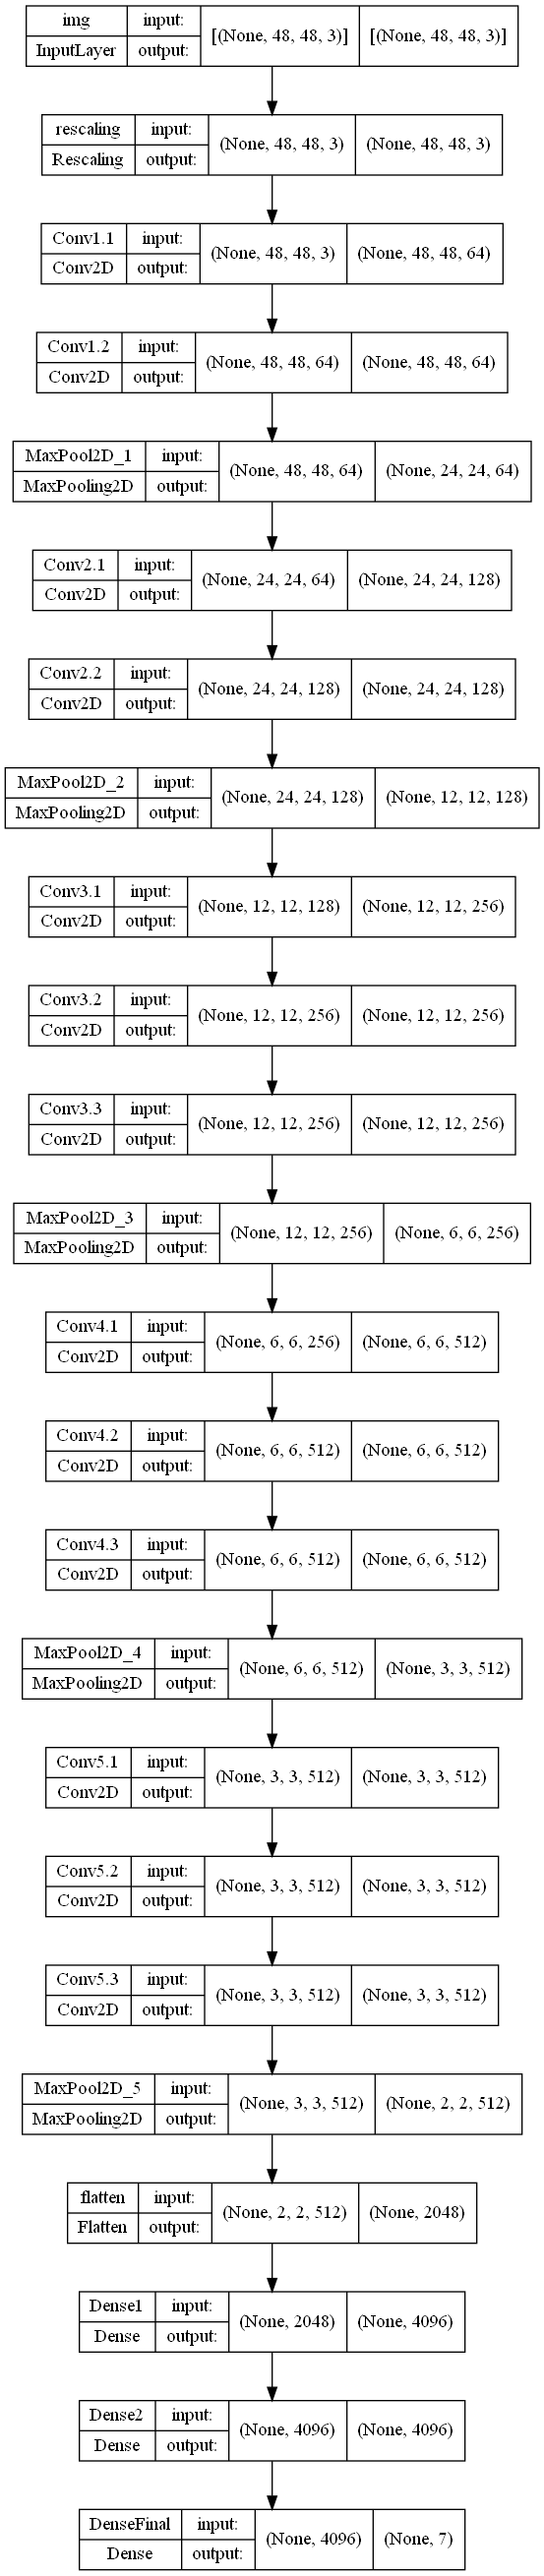

In [10]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image 


plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image('model.png', width = 400)

## Train the Model

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

name = [model_name, dataset , 'weights']
name = '_'.join(name) + ".hdf5"

checkpoint_file_path = "models/" + name


checkpoint = ModelCheckpoint(filepath=checkpoint_file_path,
                            monitor="val_loss",
                            verbose = 1,
                            save_best_only = True,
                            save_weights_only = False,
                            mode= "auto",
                            save_freq= "epoch",
                            options=None)


early_stop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0, # Minimum change in the monitored quantity to qualify as an improvemen
                          patience=20, # Number of epochs with no improvement after which training will be stopped
                          verbose=1,
                          mode='auto')

In [12]:
epochs=50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks = [checkpoint,early_stop] 
)

Epoch 1/50
35/36 [============================>.] - ETA: 0s - loss: 1.4133 - accuracy: 0.6589
Epoch 1: val_loss improved from inf to 1.31449, saving model to models\VGG16_CK+_weights.hdf5
36/36 [==============================] - 6s 126ms/step - loss: 1.4065 - accuracy: 0.6597 - val_loss: 1.3145 - val_accuracy: 0.6528
Epoch 2/50
35/36 [============================>.] - ETA: 0s - loss: 1.2852 - accuracy: 0.6607
Epoch 2: val_loss did not improve from 1.31449
36/36 [==============================] - 1s 39ms/step - loss: 1.2897 - accuracy: 0.6597 - val_loss: 1.3195 - val_accuracy: 0.6528
Epoch 3/50
35/36 [============================>.] - ETA: 0s - loss: 1.2855 - accuracy: 0.6643
Epoch 3: val_loss did not improve from 1.31449
36/36 [==============================] - 1s 39ms/step - loss: 1.2928 - accuracy: 0.6597 - val_loss: 1.4015 - val_accuracy: 0.6528
Epoch 4/50
35/36 [============================>.] - ETA: 0s - loss: 1.2557 - accuracy: 0.6643
Epoch 4: val_loss improved from 1.31449 to 1.

36/36 [==============================] - 1s 38ms/step - loss: 0.1966 - accuracy: 0.9306 - val_loss: 0.4956 - val_accuracy: 0.8542
Epoch 29/50
35/36 [============================>.] - ETA: 0s - loss: 0.2198 - accuracy: 0.9232
Epoch 29: val_loss improved from 0.40105 to 0.37946, saving model to models\VGG16_CK+_weights.hdf5
36/36 [==============================] - 4s 117ms/step - loss: 0.2250 - accuracy: 0.9184 - val_loss: 0.3795 - val_accuracy: 0.8750
Epoch 30/50
35/36 [============================>.] - ETA: 0s - loss: 0.2344 - accuracy: 0.9089
Epoch 30: val_loss did not improve from 0.37946
36/36 [==============================] - 1s 38ms/step - loss: 0.2286 - accuracy: 0.9115 - val_loss: 0.4013 - val_accuracy: 0.8681
Epoch 31/50
35/36 [============================>.] - ETA: 0s - loss: 0.2396 - accuracy: 0.9179
Epoch 31: val_loss did not improve from 0.37946
36/36 [==============================] - 1s 40ms/step - loss: 0.2403 - accuracy: 0.9167 - val_loss: 0.4723 - val_accuracy: 0.8472

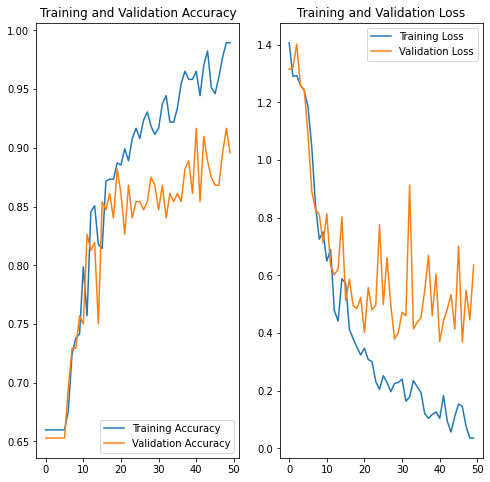

In [15]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluate the Model

In [17]:
print("Evaluate")
model.load_weights(checkpoint_file_path) #Load the best weights from the file
result = model.evaluate(test_ds)
dict(zip(model.metrics_names, result))

Evaluate


NameError: name 'checkpoint_file_path' is not defined